In [2]:
%load_ext autoreload
%autoreload 3
from Probe import get_pdata, probe_shapelet
import numpy as np
import utils
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [3]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [4]:
from tsai.models.FCN import FCN
model_path = 'models/GunPoint/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()

train_x, test_x, train_y, test_y, enc1 = utils.read_UCR_UEA('GunPoint', None)
test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)

instance_length = train_x.shape[-1]

with open(f'shapelets/GunPoint/RSTF.pkl', 'rb') as f:
    ST_attribution = pickle.load(f)
# pick the first Shapelet
info_gain, shapelet_length, start_pos, dimension, inst_index, shapelet_class, z_norm_shapelet = ST_attribution.shapelets[0]

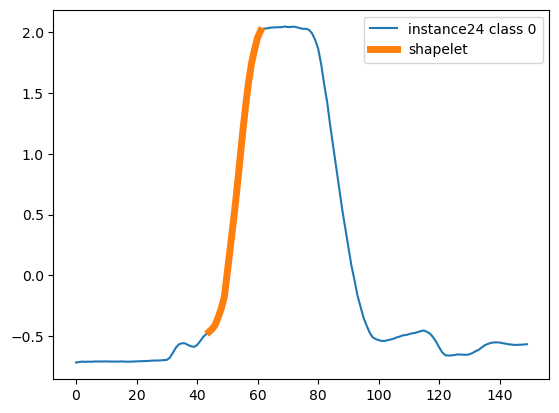

In [48]:
plt.plot(train_x[inst_index].flatten(),label=f'instance{inst_index} class {shapelet_class}')
plt.plot(np.arange(start_pos,start_pos+shapelet_length),train_x[inst_index,:,start_pos:start_pos+shapelet_length].flatten(),
         linewidth=5,label='shapelet')
plt.legend()

In [49]:
pdata = get_pdata(shapelet=z_norm_shapelet, selected_datasets=utils.selected_uni, inst_length=instance_length, 
                   num_shapelet=1, is_add=False, repeat_max=100,
                       is_z_norm=True, save_dir='probe/GunPoint')

dealing with ECG200: (100, 1, 96)
dealing with Beef: (30, 1, 470)
dealing with ElectricDevices: (8926, 1, 96)
dealing with Earthquakes: (322, 1, 512)
dealing with Wafer: (1000, 1, 152)
dealing with PowerCons: (180, 1, 144)
dealing with NonInvasiveFetalECGThorax1: (1800, 1, 750)
dealing with ECG5000: (500, 1, 140)
dealing with GunPoint: (50, 1, 150)
dealing with HandOutlines: (1000, 1, 2709)
dealing with CBF: (30, 1, 128)
dealing with FordA: (3601, 1, 500)
dealing with TwoPatterns: (1000, 1, 128)
dealing with UWaveGestureLibraryAll: (896, 1, 945)
dealing with Chinatown: (20, 1, 24)
dealing with Yoga: (300, 1, 426)
dealing with DistalPhalanxOutlineCorrect: (600, 1, 80)
dealing with Computers: (250, 1, 720)
dealing with ShapesAll: (600, 1, 512)
dealing with Strawberry: (613, 1, 235)


In [6]:
with open('probe/GunPoint/pdata.pkl','rb') as f:
    pdata = pickle.load(f)

In [9]:
pdata = np.concatenate((pdata['pdata_ws'],pdata['pdata_wos']), axis=-1)

In [10]:
print(len(z_norm_shapelet))

18


In [18]:
results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=model, 
                         shapelet=z_norm_shapelet, pos=start_pos, device='cuda:1')

(50, 128) (1730, 128)
Training Accuracy = 1.00
----------------------
Accuracy = 0.04
Precision = 0.00
Recall = 0.00
F1 Score = 0.00
